<a href="https://colab.research.google.com/github/Cuzime/ASTRON-128/blob/main/ZTF_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch, MinMaxInterval, SqrtStretch, ImageNormalize, SinhStretch
from sklearn.preprocessing import PowerTransformer
import random
import math
import keras
import os
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from sklearn.preprocessing import StandardScaler
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow_probability as tfp
import time
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, False)

Tensorflow Version: 2.14.0
Num GPUs Available:  0
[]


In [ ]:
wandb.login()

In [11]:
# set size of stamps
size = 256
stamps_per_img = 300
step = int(size/2)

def get_image(index, quad):
    file_name = file_list[index]
    file_path = folder_path + file_name
    hdu_1 = fits.open(file_path)
    image_data = hdu_1[quad].data
    hdu_1.close()

    return image_data

def visual_transform_image(image):
    # VISUALIZE THE DATA

    # Scale the image based on its percentiles
    interval = PercentileInterval(99.5)
    vmin, vmax = interval.get_limits(image)
    norm = plt.Normalize(vmin, vmax)

    # Apply an asinh stretch to enhance faint features
    stretch = AsinhStretch()
    scaled_data = stretch(norm(image))

    return scaled_data

def get_stamps(image):
    # get image dimensions
    naxis1,naxis2 = np.shape(image)
    x_centers = np.arange(step, naxis1-step, step)
    y_centers = np.arange(step, naxis2-step, step)
    stamps = []
    for x_center in x_centers:
        for y_center in y_centers:
            stamp = image[y_center-step:y_center+step, x_center-step:x_center+step]
            stamps.append(stamp)

    stamps = np.array(stamps)

    return stamps.reshape(stamps.shape[0], stamps.shape[1], stamps.shape[2], 1)

# ZTF raw stamps generator

In [5]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-001.zip > /dev/null

In [6]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-002.zip > /dev/null

In [7]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-003.zip > /dev/null

In [8]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstamps-20231110T010353Z-004.zip > /dev/null

In [9]:
# unzip masks
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-20231110T010359Z-001.zip > /dev/null

In [10]:
! unzip /content/drive/MyDrive/ZTFrawdatazips/ZTFrawstampsmask-20231110T010359Z-002.zip > /dev/null

61685
61685
0.3105897903442383
(15, 256, 256, 1)
(15, 256, 256, 1)


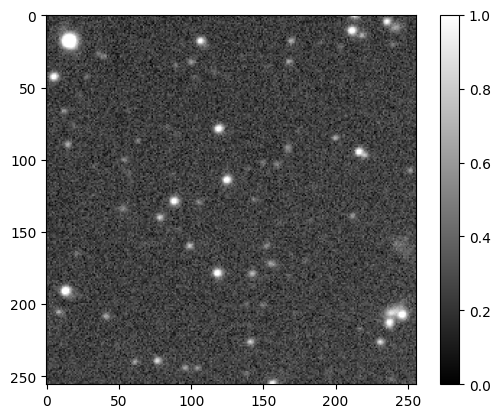

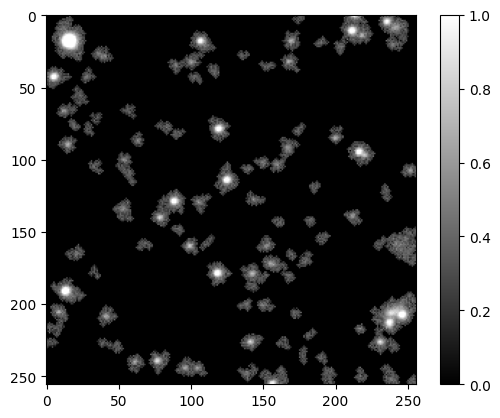

In [12]:
# raw stamps generator

folder_path = '/content/ZTFrawstamps'
file_list = os.listdir(folder_path)

folder_path_masks = '/content/ZTFrawstampsmask'
file_list_masks = os.listdir(folder_path_masks)

full_path_list = []
for file_name in file_list:
  file_path = folder_path + '/' + file_name
  full_path_list.append(file_path)

print(len(full_path_list))

mask_path_list = []
for file_name in file_list_masks:
  file_path = folder_path_masks + '/' + file_name
  mask_path_list.append(file_path)

print(len(mask_path_list))

def generate_train_stamps_mask_raw(batch_size):
  while True:
    counter = 0
    stamp_list = []
    mask_list = []
    for file_path in full_path_list:
      if (counter == batch_size):
        counter = 0
        yield (np.array(stamp_list), np.array(mask_list))
        stamp_list = []
        mask_list = []

      image_data = np.load(file_path)
      mask_data = np.load('/content/ZTFrawstampsmask/' + file_path[22:-4] + '_mask.npy')
      mask_data = mask_data.reshape(256,256,1)

      mask_list.append(mask_data)
      stamp_list.append(image_data)
      counter += 1

gen = generate_train_stamps_mask_raw(15)

start = time.time()
for i in range(3):
  stamps, masks = next(gen)
end = time.time()
print(end-start)
print(np.shape(stamps))
print(np.shape(masks))

plt.imshow(visual_transform_image(stamps[0]).reshape(256,256),cmap = 'gray')
plt.colorbar()

# apply mask to image
masked_stamp = visual_transform_image(stamps[0])*masks[0].reshape(256,256,1)

plt.figure()
plt.imshow(masked_stamp.reshape(256,256),cmap = 'gray')
plt.colorbar()

# PixelCNN Autoencoder

In [13]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [15]:
shape = (size, size)
input_shape = (size, size, 1)

# PixelCNN Autoencoder
class PCNNae(keras.Model):

    def gae_compile(self,
                    encoder,
                    mean_model,
                    var_model,
                    encoder_optimizer,
                    mean_optimizer,
                    var_optimizer,
                    epsilon=1,
                    beta = 1,
                    **kwargs):
        super().compile()
        self.mean_optimizer = mean_optimizer
        self.var_optimizer = var_optimizer
        self.encoder_optimizer = encoder_optimizer
        self.mle_loss_tracker = keras.metrics.Mean(name="mle_loss")
        #self.kl_loss_tracker = keras.metrics.Mean(name ="kl_loss")
        self.var_loss_tracker = keras.metrics.Mean(name="var_loss")
        self.mse_tracker = keras.metrics.Mean(name = "mse")
        self.beta = beta
        self.epsilon = epsilon
        self.mean_model = mean_model
        self.var_model = var_model
        self.encoder = encoder

    def train_step(self, data):
        stamps, masks = data
        masks = tf.cast(masks, tf.float32)

        """"FULLY CONV MODEL WITHOUT TUNING"""
        with tf.GradientTape(persistent = True) as tape:
            # forward pass mean
            codes = self.encoder(stamps, training = True)

            mean_img = self.mean_model(codes, training = True)
            """Calculate MSE loss"""
            # added element wise multiplication with masks
            mse = K.mean(tf.math.multiply(K.square(mean_img - stamps), masks))

        # apply gradients to mean model
        mean_grads = tape.gradient(mse, self.mean_model.trainable_weights)
        encoder_grads = tape.gradient(mse, self.encoder.trainable_weights)
        self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.mean_optimizer.apply_gradients(zip(mean_grads, self.mean_model.trainable_weights))

        with tf.GradientTape(persistent = True) as tape:
            # forward pass variance
            codes = self.encoder(stamps, training = True)

            var_img = self.var_model(codes, training = True)
            mean_img = self.mean_model(codes, training = False)

            """Calulate MLE loss"""
            mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - stamps) / (var_img+self.epsilon)
            mle_loss = K.mean(mle_loss)

            "Variance Loss"
            var_loss = mle_loss

        # apply gradients to var model
        var_grads = tape.gradient(var_loss, self.var_model.trainable_weights)
        self.var_optimizer.apply_gradients(zip(var_grads, self.var_model.trainable_weights))
        # encoder_grads = tape.gradient(var_loss, self.encoder.trainable_weights)
        # self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))

        # update state of trackers
        self.mle_loss_tracker.update_state(mle_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.mse_tracker.update_state(mse)

        return {
            "mse": self.mse_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
            "mle_loss": self.mle_loss_tracker.result()
        }

    def test_step(self, data):

        stamps,mask = data

        # forward pass
        codes = self.encoder(stamps, training = False)
        """"masking process"""
        #codes_shape = K.int_shape(codes)[1:]
        #comp_param = random.randint(1,64)
        #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        #codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)
        #var_img = tf.abs(var_img)
        """Calculate MSE loss"""
        # added element wise multiplication with masks
        mse = K.mean(tf.math.multiply(K.square(mean_img - stamps), masks))

        """"Calculate MLE loss"""
        mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - stamps) / (var_img+self.epsilon)
        mle_loss = K.mean(mle_loss)

        "Variance Loss"
        var_loss = mle_loss

        self.mse_tracker.reset_states()
        self.mle_loss_tracker.reset_states()
        self.var_loss_tracker.reset_states()
        #self.kl_loss_tracker.reset_states()
        #self.kl_loss_tracker.update_state(kl_loss)
        self.mse_tracker.update_state(mse)
        self.mle_loss_tracker.update_state(mle_loss)
        self.var_loss_tracker.update_state(var_loss)

        return {
            "mse": self.mse_tracker.result(),
            "var_loss": self.var_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
            "mle_loss": self.mle_loss_tracker.result()
        }

    def custom_predict(self, data, comp_param):
        x = data
        # forward pass
        codes = self.encoder(x, training = False)
        """"masking process"""
        codes_shape = K.int_shape(codes)[1:]
        comp_param = comp_param
        #mask = create_mask(codes_shape = codes_shape, comp_param = comp_param)
        #codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        return mean_img, var_img

In [21]:
# set hyperparameters
epochs = 300
batch_size = 64
steps_per_epoch = 500
learning_rate = 0.001
noise_std = 0.1
epsilon = noise_std**2
#percentile_interval = 99.5
#a = 0.1
beta = 0

# PixelCNN autoencoder architecture

with tf.device(device_name = '/device:GPU:0'):

    input = keras.Input(shape = input_shape)
    enc_layer = input

    # encoder
    enc_layer = PixelConvLayer(mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same")(enc_layer)
    enc_layer = keras.layers.BatchNormalization()(enc_layer)

    enc_layer = keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same')(enc_layer)
    enc_layer = keras.layers.BatchNormalization()(enc_layer)
    enc_layer = keras.layers.MaxPooling2D((2,2), padding = 'same')(enc_layer)

    enc_layer = keras.layers.Conv2D(2, (3,3), activation = 'relu', padding = 'same')(enc_layer)
    enc_layer = keras.layers.BatchNormalization()(enc_layer)
    enc_layer = keras.layers.MaxPooling2D((2,2), padding = 'same')(enc_layer)

    #shape_before_flatten = K.int_shape(enc_layer)[1:]

    mean_layer = enc_layer

    mean_layer = keras.layers.Conv2DTranspose(128, (3,3), activation = 'relu', padding = 'same')(mean_layer)
    mean_layer = keras.layers.BatchNormalization()(mean_layer)
    mean_layer = keras.layers.UpSampling2D((2,2))(mean_layer)

    mean_layer = keras.layers.Conv2DTranspose(128, (3,3), activation = 'relu', padding = 'same')(mean_layer)
    mean_layer = keras.layers.BatchNormalization()(mean_layer)
    mean_layer = keras.layers.UpSampling2D((2,2))(mean_layer)

    mean_layer = ResidualBlock(filters=128)(mean_layer)
    mean_layer = ResidualBlock(filters=128)(mean_layer)

    mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(mean_layer)
    mean_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(mean_layer)
    mean_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="linear", padding="same")(mean_layer)

    var_layer = enc_layer

    var_layer = keras.layers.Conv2DTranspose(128, (3,3), activation = 'relu', padding = 'same')(var_layer)
    var_layer = keras.layers.BatchNormalization()(var_layer)
    var_layer = keras.layers.UpSampling2D((2,2))(var_layer)

    var_layer = keras.layers.Conv2DTranspose(128, (3,3), activation = 'relu', padding = 'same')(var_layer)
    var_layer = keras.layers.BatchNormalization()(var_layer)
    var_layer = keras.layers.UpSampling2D((2,2))(var_layer)

    var_layer = ResidualBlock(filters=128)(var_layer)
    var_layer = ResidualBlock(filters=128)(var_layer)

    var_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(var_layer)
    var_layer = PixelConvLayer(mask_type="B", filters=128, kernel_size=1,strides=1,activation="relu",padding="same")(var_layer)
    var_predict = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="relu", padding="same")(var_layer)


    mean_model = keras.Model(enc_layer, mean_predict, name = 'mean_model')
    var_model = keras.Model(enc_layer, var_predict, name = 'var_model')

    encoder = keras.Model(input, enc_layer, name = 'encoder')

    autoencoder_C = PCNNae(input, [mean_predict, var_predict])
    mean_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    var_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    autoencoder_C.gae_compile(mean_model = mean_model, var_model = var_model, encoder = encoder,
                                mean_optimizer=mean_optimizer, var_optimizer = var_optimizer,
                                encoder_optimizer = encoder_optimizer,
                                epsilon = epsilon,
                                beta = beta
                                )

    encoder.summary()
    mean_model.summary()
    var_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 pixel_conv_layer_21 (Pixel  (None, 256, 256, 128)     6400      
 ConvLayer)                                                      
                                                                 
 batch_normalization_16 (Ba  (None, 256, 256, 128)     512       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 256, 256, 128)     147584    
                                                                 
 batch_normalization_17 (Ba  (None, 256, 256, 128)     512       
 tchNormalization)                                               
                                                           